In [79]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import pandas as pd
import theano
import arviz as az

from scipy import stats
import xarray as xr

import itertools
from theano import tensor as tt

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (8,5)
#WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.

In [80]:
data = pd.read_csv("./IMA_recommendation_simulation_data.csv")
data = data.dropna()
data.head()

,Unnamed: 0,request_id,week_id,weekday,miles,order_equipment_type,order_distance,order_num_stops,order_origin_weight,lead_days,color,origin_dat_ref,dest_dat_ref,rate_norm,est_cost_norm,CurrentCondition
0,0,c2653eda11cd4d94879d1946392eb2b5,4,Sat,1856,V,1848.0,2,40000.0,3,RED,633,978,2.273442,2.138631,Accepted
1,1,65e3dcc84a2246e68ea8636a967b31b2,3,Mon,56,V,47.0,2,12729.0,3,RED,604,604,-0.971030,-1.017024,Rejected
2,2,0a86f005640a4204b46c95ca033a7ced,1,Fri,259,V,255.0,2,44176.0,3,RED,761,770,-0.393352,-0.475805,Accepted
3,3,1105b4bc7b444f7985d4ad810e7acbc2,3,Thu,71,V,68.0,2,39847.0,6,RED,187,180,-0.706546,-0.765855,Rejected
4,4,de538100bb0f4137961b9551640ef35e,3,Fri,1182,R,1183.0,2,34912.0,3,GREEN,972,922,1.014233,0.469273,Accepted


In [81]:
def zz(value):
    if value < 100:
        return 'Z0'
    elif value < 200:
        return 'Z1'
    elif value < 300:
        return 'Z2'
    elif value < 400:
        return 'Z3'
    elif value < 500:
        return 'Z4'
    elif value < 600:
        return 'Z5'
    elif value < 700:
        return 'Z6'
    elif value < 800:
        return 'Z7'
    elif value < 900:
        return 'Z8'
    elif value < 1000:
        return 'Z9'
    else:
        return 'Error'


data['ZipZone_origin'] = data.apply(lambda column: zz(column['origin_dat_ref']),axis=1)
data['ZipZone_dest'] = data.apply(lambda column: zz(column['dest_dat_ref']),axis=1)

In [82]:
data = data.dropna()
#data = data[data['ZipZone_origin'] == data['ZipZone_dest']]
data = data[data['lead_days'] >= 0]

In [83]:
data['order_distance_norm'] = (data['order_distance'] - data['order_distance'].mean())/(data['order_distance'].std())
data['weight_norm'] = (data['order_origin_weight'] - data['order_origin_weight'].mean())/(data['order_origin_weight'].std())
data['lead_days_norm'] = (data['lead_days'] - data['lead_days'].mean())/(data['lead_days'].std())

In [84]:
from sklearn.preprocessing import LabelEncoder

sch_le = LabelEncoder()

zipzone = sch_le.fit_transform(data['ZipZone_origin'])
n_zipzones = len(sch_le.classes_)
order_distance_norm = data.order_distance_norm
weight_norm = data.weight_norm
lead_days_norm = data.lead_days_norm
rate_norm = data.rate_norm
est_cost_norm = data.est_cost_norm

order_distance_norm = np.array(order_distance_norm.values.tolist())
weight_norm = np.array(weight_norm.values.tolist())
lead_days_norm = np.array(lead_days_norm.values.tolist())
rate_norm = np.array(rate_norm.values.tolist())
est_cost_norm = np.array(est_cost_norm.tolist())

# First rate model

In [85]:
# Model to generate rate_norm values

with pm.Model() as rate_model:
    x1_shared = pm.Data("distance", order_distance_norm)
    x2_shared = pm.Data("weight", weight_norm)
    x3_shared = pm.Data("leaddays", lead_days_norm)
    y_shared = pm.Data("rate", rate_norm)
    
    # Hyperpriors
    mu_intercept = pm.Normal('mu_intercept', mu=-1, sigma=1)
    sigma_intercept = pm.Exponential('sigma_intercept', 1) # Possibly change these sigma distributions (Normal doesn't work)
    
    mu_distance = pm.Normal('mu_distance', mu=0, sigma=1)
    sigma_distance = pm.Exponential('sigma_distance', 1)
    
    mu_weight = pm.Normal('mu_weight', mu=0, sigma=1)
    sigma_weight = pm.Exponential('sigma_weight', 1)
    
    mu_leaddays = pm.Normal('mu_leaddays', mu=0, sigma=1)
    sigma_leaddays = pm.Exponential('sigma_leaddays', 1)
    
    # Intercept Prior
    intercept = pm.Normal('intercept', mu=mu_intercept, sigma=sigma_intercept, shape = n_zipzones)
    # order_distance_norm Coefficient Prior
    distance_coef = pm.Normal('distance_coef', mu=mu_distance, sigma=sigma_distance, shape = n_zipzones)
    # weight_norm Coefficient Prior
    weight_coef = pm.Normal('weight_coef', mu=mu_weight, sigma=sigma_weight, shape = n_zipzones)
    # lead_days_norm Coefficient Prior
    leaddays_coef = pm.Normal('leaddays_coef', mu=mu_leaddays, sigma=sigma_leaddays, shape = n_zipzones)
    
    # Model error
    epsilon = pm.HalfNormal('epsilon', 1) # Possibly change distribution
    
    y_hat = intercept[zipzone] + distance_coef[zipzone] * x1_shared + weight_coef[zipzone] * x2_shared + leaddays_coef[zipzone] * x3_shared
    
    # Likelihood
    pm.Normal('y_like', mu=y_hat, sigma=epsilon, observed=y_shared)
    
    rate_trace = pm.sample(1000, cores=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, leaddays_coef, weight_coef, distance_coef, intercept, sigma_leaddays, mu_leaddays, sigma_weight, mu_weight, sigma_distance, mu_distance, sigma_intercept, mu_intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1356 seconds.


In [86]:
Z3_data = data[data['ZipZone_origin'] == 'Z3']

Z3_distance = Z3_data.order_distance_norm
Z3_distance = np.array(Z3_distance.values.tolist())

Z3_weight = Z3_data.weight_norm
Z3_weight = np.array(Z3_weight.values.tolist())

Z3_leaddays = Z3_data.lead_days_norm
Z3_leaddays = np.array(Z3_leaddays.values.tolist())

In [87]:
with rate_model:
    post_pred = pm.sample_posterior_predictive(rate_trace, var_names = ['y_like'])

In [92]:
post_pred['y_like'].shape

(2000, 154929)

C:\Users\laure\anaconda3\lib\site-packages\arviz\stats\density_utils.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  t_j = np.power((c1 * (c2 / (N * f))), (2.0 / (3.0 + 2.0 * j)))
C:\Users\laure\anaconda3\lib\site-packages\arviz\stats\density_utils.py:252: RuntimeWarning: divide by zero encountered in double_scalars
  out = t - (2 * N * np.pi ** 0.5 * f) ** (-0.4)
C:\Users\laure\anaconda3\lib\site-packages\arviz\stats\density_utils.py:276: RuntimeWarning: invalid value encountered in double_scalars
  bw = (_bw_silverman(x) / np.ptp(x)) ** 2
C:\Users\laure\anaconda3\lib\site-packages\arviz\stats\density_utils.py:760: RuntimeWarning: invalid value encountered in true_divide
  f = grid_counts / bin_width / len(x)
C:\Users\laure\anaconda3\lib\site-packages\arviz\stats\density_utils.py:770: UserWarning: Something failed when estimating the bandwidth. Please check your data
  warnings.warn("Something failed when estimating the bandwidth. Please check your data")


<AxesSubplot:xlabel='y_like'>

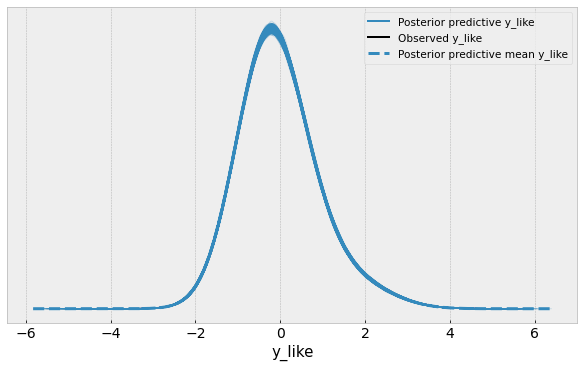

In [93]:
az.plot_ppc(az.from_pymc3(posterior_predictive=post_pred, model=rate_model))

In [94]:
# See how well rate_model generates data that resembles the true Z3->Z3 data (using original columns, not generated columns)
with rate_model:
    # change the value and shape of the data
    pm.set_data(
        {
            "distance": np.concatenate((Z3_distance, np.empty((data.shape)[0] - len(Z3_distance)))),
            "weight": np.concatenate((Z3_weight, np.empty((data.shape)[0] - len(Z3_weight)))),
            "leaddays": np.concatenate((Z3_leaddays, np.empty((data.shape)[0] - len(Z3_leaddays)))),
            # use dummy values with the same shape:
            "rate": np.empty(data.shape[0]),
        }
    )
    rate_post_pred = pm.sample_posterior_predictive(rate_trace, var_names=['y_like'])

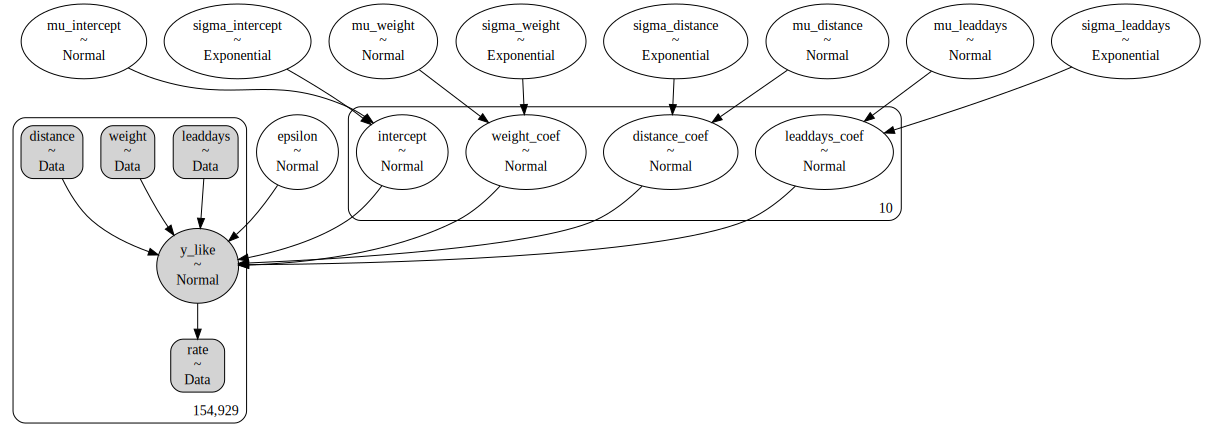

In [89]:
pm.model_to_graphviz(rate_model)

In [61]:
summary = az.summary(rate_trace, round_to=8)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,-0.521908,0.050412,-0.614070,-0.428203,0.000825,0.000584,3731.885128,3731.885128,4342.989357,2632.032545,1.005727
mu_b,0.309298,0.036790,0.241665,0.379788,0.000609,0.000438,3654.358675,3530.590836,4025.397638,2404.460578,1.001675
mu_c,-0.004202,0.028173,-0.059552,0.047390,0.000430,0.000497,4293.735504,1605.884886,4614.698552,2236.318945,1.000673
mu_d,-0.012467,0.009528,-0.030481,0.005503,0.000149,0.000137,4089.523176,2410.880060,4435.258614,2447.935282,1.001117
a[0],-0.444056,0.011813,-0.465550,-0.422073,0.000185,0.000132,4057.747015,4028.805063,4032.539662,3219.061197,1.001496
a[1],-0.289303,0.011563,-0.312149,-0.268684,0.000184,0.000130,3945.979282,3935.317945,3939.160693,3145.889395,0.999657
a[2],-0.572558,0.010214,-0.592604,-0.554300,0.000142,0.000100,5167.148209,5167.148209,5177.889501,3185.570623,1.000138
a[3],-0.419941,0.004147,-0.427584,-0.411944,0.000049,0.000034,7308.336283,7308.336283,7313.226807,2904.472783,1.000929
a[4],-0.625408,0.006160,-0.636287,-0.613291,0.000084,0.000060,5361.307702,5361.307702,5321.784863,3105.537509,1.000725
a[5],-0.703208,0.011354,-0.724330,-0.681741,0.000155,0.000109,5386.275321,5376.639026,5388.422078,3214.852961,1.000451


<ipython-input-62-198d2f3e09c8>:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(rate_trace)


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_c'}>,
        <AxesSubplot:title={'center':'mu_c'}>],
       [<AxesSubplot:title={'center':'mu_d'}>,
        <AxesSubplot:title={'center':'mu_d'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'d'}>,
        <AxesSubplot:title={'center':'d'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot

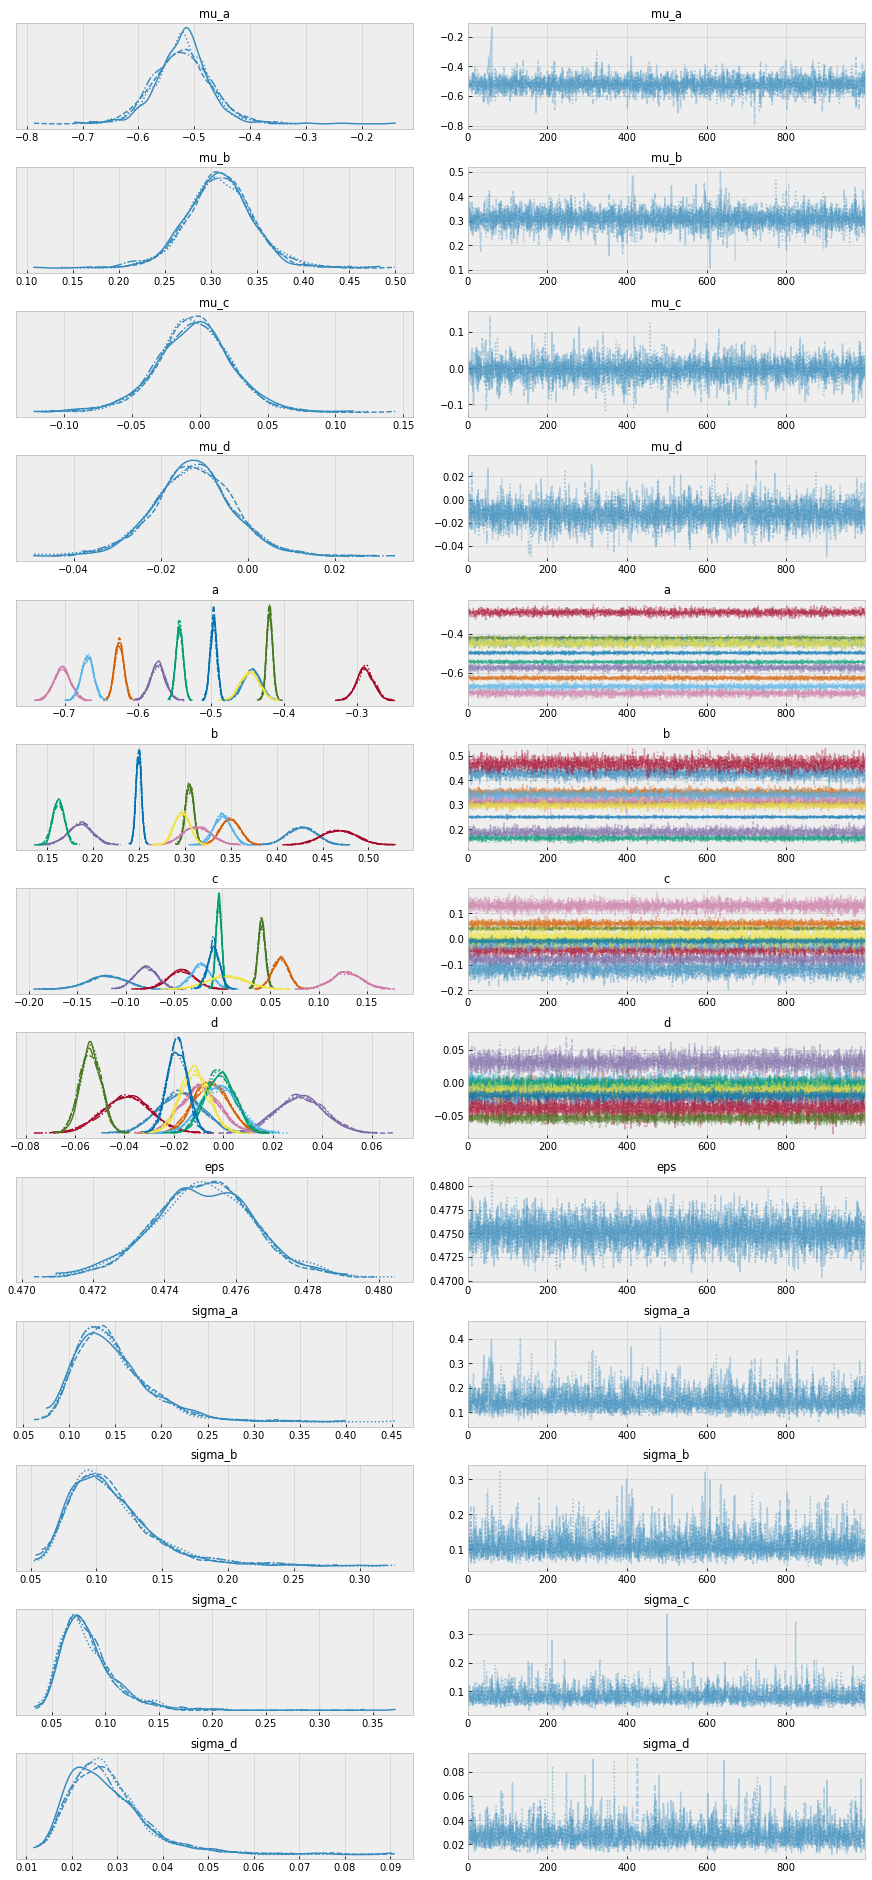

In [62]:
from pymc3 import traceplot

traceplot(rate_trace)

C:\Users\laure\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\laure\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


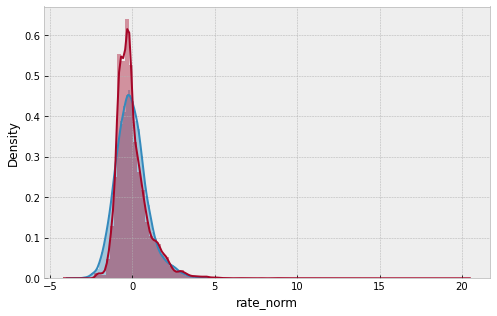

In [95]:
fig, ax = plt.subplots()
x = rate_post_pred["y_like"][0,0:len(Z3_distance)]
y = Z3_data['rate_norm']
for a in [x, y]:
    sns.distplot(a, bins=100, ax=ax)
#ax.set_xlim([0, 100])

In [107]:
# Something fishy is going on with the histogram below...
under5 = Z3_data[Z3_data['rate_norm'] < 5]
print(under5.shape)
s = Z3_data.shape[0]
t = Z3_data[Z3_data['rate_norm'] >= 5].shape[0]
print(s)
print(under5.shape[0]+t)
print(Z3_data['rate_norm'].shape[0])

(28856, 21)
28909
28909
28909


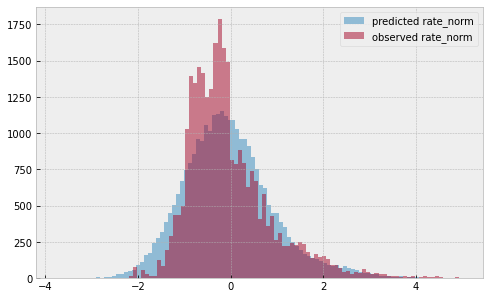

In [110]:
plt.hist(rate_post_pred["y_like"][0,0:len(Z3_distance)], bins=100, alpha=0.5, label='predicted rate_norm')
plt.hist(under5['rate_norm'], bins=100, alpha=0.5, label='observed rate_norm') # If under5 is replaced by Z3_data, the histogram should look the same
plt.legend(loc='upper right')
plt.show()

# First cost model

In [111]:
# Model to generate est_cost_norm values

with pm.Model() as cost_model:
    x1_shared = pm.Data("distance", order_distance_norm)
    x2_shared = pm.Data("weight", weight_norm)
    x3_shared = pm.Data("leaddays", lead_days_norm)
    y_shared = pm.Data("cost", est_cost_norm)
    
    # Hyperpriors
    mu_intercept = pm.Normal('mu_intercept', mu=-1, sigma=1)
    sigma_intercept = pm.Exponential('sigma_intercept', 1) # Possibly change these sigma distributions (Normal doesn't work)

    mu_distance = pm.Normal('mu_distance', mu=0, sigma=1)
    sigma_distance = pm.Exponential('sigma_distance', 1)
    
    mu_weight = pm.Normal('mu_weight', mu=0, sigma=1)
    sigma_weight = pm.Exponential('sigma_weight', 1)
    
    mu_leaddays = pm.Normal('mu_leaddays', mu=0, sigma=1)
    sigma_leaddays = pm.Exponential('sigma_leaddays', 1)
    
    # Intercept Prior
    intercept = pm.Normal('intercept', mu=mu_intercept, sigma=sigma_intercept, shape = n_zipzones)
    # order_distance_norm Coefficient Prior
    distance_coef = pm.Normal('distance_coef', mu=mu_distance, sigma=sigma_distance, shape = n_zipzones)
    # weight_norm Coefficient Prior
    weight_coef = pm.Normal('weight_coef', mu=mu_weight, sigma=sigma_weight, shape = n_zipzones)
    # lead_days_norm Coefficient Prior
    leaddays_coef = pm.Normal('leaddays_coef', mu=mu_leaddays, sigma=sigma_leaddays, shape = n_zipzones)
    
    # Model error
    epsilon = pm.HalfNormal('epsilon', 1) # Possibly change distribution
    
    y_hat = intercept[zipzone] + distance_coef[zipzone] * x1_shared + weight_coef[zipzone] * x2_shared + leaddays_coef[zipzone] * x3_shared
    
    # Likelihood
    pm.Normal('y_like', mu=y_hat, sigma=epsilon, observed=y_shared)
    
    cost_trace = pm.sample(1000, cores=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, leaddays_coef, weight_coef, distance_coef, intercept, sigma_leaddays, mu_leaddays, sigma_weight, mu_weight, sigma_distance, mu_distance, sigma_intercept, mu_intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1452 seconds.


In [115]:
with cost_model:
    post_pred = pm.sample_posterior_predictive(rate_trace, var_names = ['y_like']) # change rate_trace to cost_trace

<AxesSubplot:xlabel='y_like'>

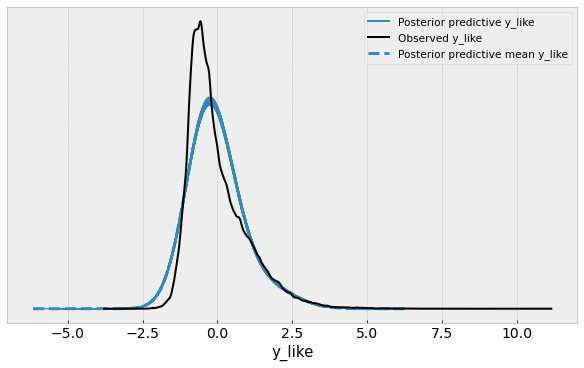

In [116]:
az.plot_ppc(az.from_pymc3(posterior_predictive=post_pred, model=cost_model))

In [117]:
# See how well cost_model generates data that resembles the true Z3->Z3 data (using original columns, not generated columns)
with cost_model:
    # change the value and shape of the data
    pm.set_data(
        {
            "distance": np.concatenate((Z3_distance, np.empty((data.shape)[0] - len(Z3_distance)))),
            "weight": np.concatenate((Z3_weight, np.empty((data.shape)[0] - len(Z3_weight)))),
            "leaddays": np.concatenate((Z3_leaddays, np.empty((data.shape)[0] - len(Z3_leaddays)))),
            # use dummy values with the same shape:
            "cost": np.empty(data.shape[0]),
        }
    )
    cost_post_pred = pm.sample_posterior_predictive(rate_trace, var_names=['y_like']) # change rate_trace to cost_trace

In [121]:
costimage = pm.model_to_graphviz(cost_model)

In [124]:
with open('cost_model_pic.svg', 'w') as f:
    f.write(costimage._repr_svg_())

In [74]:
summary = az.summary(cost_trace, round_to=8)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,-0.560907,0.064642,-0.694638,-0.446000,0.000926,0.000658,4875.397286,4830.916400,5211.105265,2815.668957,1.003395
mu_b,0.336408,0.048562,0.244232,0.430857,0.000679,0.000483,5115.386147,5056.166385,5232.005311,2914.350699,1.002315
mu_c,-0.006118,0.019026,-0.041798,0.028469,0.000294,0.000289,4197.904772,2168.745124,4370.260287,2263.637528,1.003898
mu_d,0.003789,0.014737,-0.022174,0.032995,0.000222,0.000249,4390.450333,1751.283531,4732.738903,2702.614135,1.001397
a[0],-0.387355,0.010720,-0.407106,-0.366824,0.000169,0.000120,4007.912018,4007.912018,4010.345591,3249.455537,0.999836
a[1],-0.332480,0.011546,-0.353660,-0.310483,0.000166,0.000117,4843.970554,4833.963475,4858.072353,3397.331583,0.999780
a[2],-0.618458,0.010072,-0.636689,-0.599905,0.000148,0.000105,4612.135693,4598.534770,4606.248917,2967.916432,1.002436
a[3],-0.463102,0.004032,-0.470974,-0.456077,0.000046,0.000033,7557.826186,7545.932104,7550.820728,2559.838122,1.000684
a[4],-0.648438,0.005940,-0.659641,-0.637084,0.000077,0.000054,6021.425557,6011.216169,6044.952902,3274.709806,0.999622
a[5],-0.858624,0.010958,-0.879002,-0.837896,0.000127,0.000090,7402.884936,7389.204328,7441.270395,2865.272793,1.003831


<ipython-input-75-19dbe39e5330>:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  traceplot(cost_trace)


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'mu_c'}>,
        <AxesSubplot:title={'center':'mu_c'}>],
       [<AxesSubplot:title={'center':'mu_d'}>,
        <AxesSubplot:title={'center':'mu_d'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'d'}>,
        <AxesSubplot:title={'center':'d'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <Axe

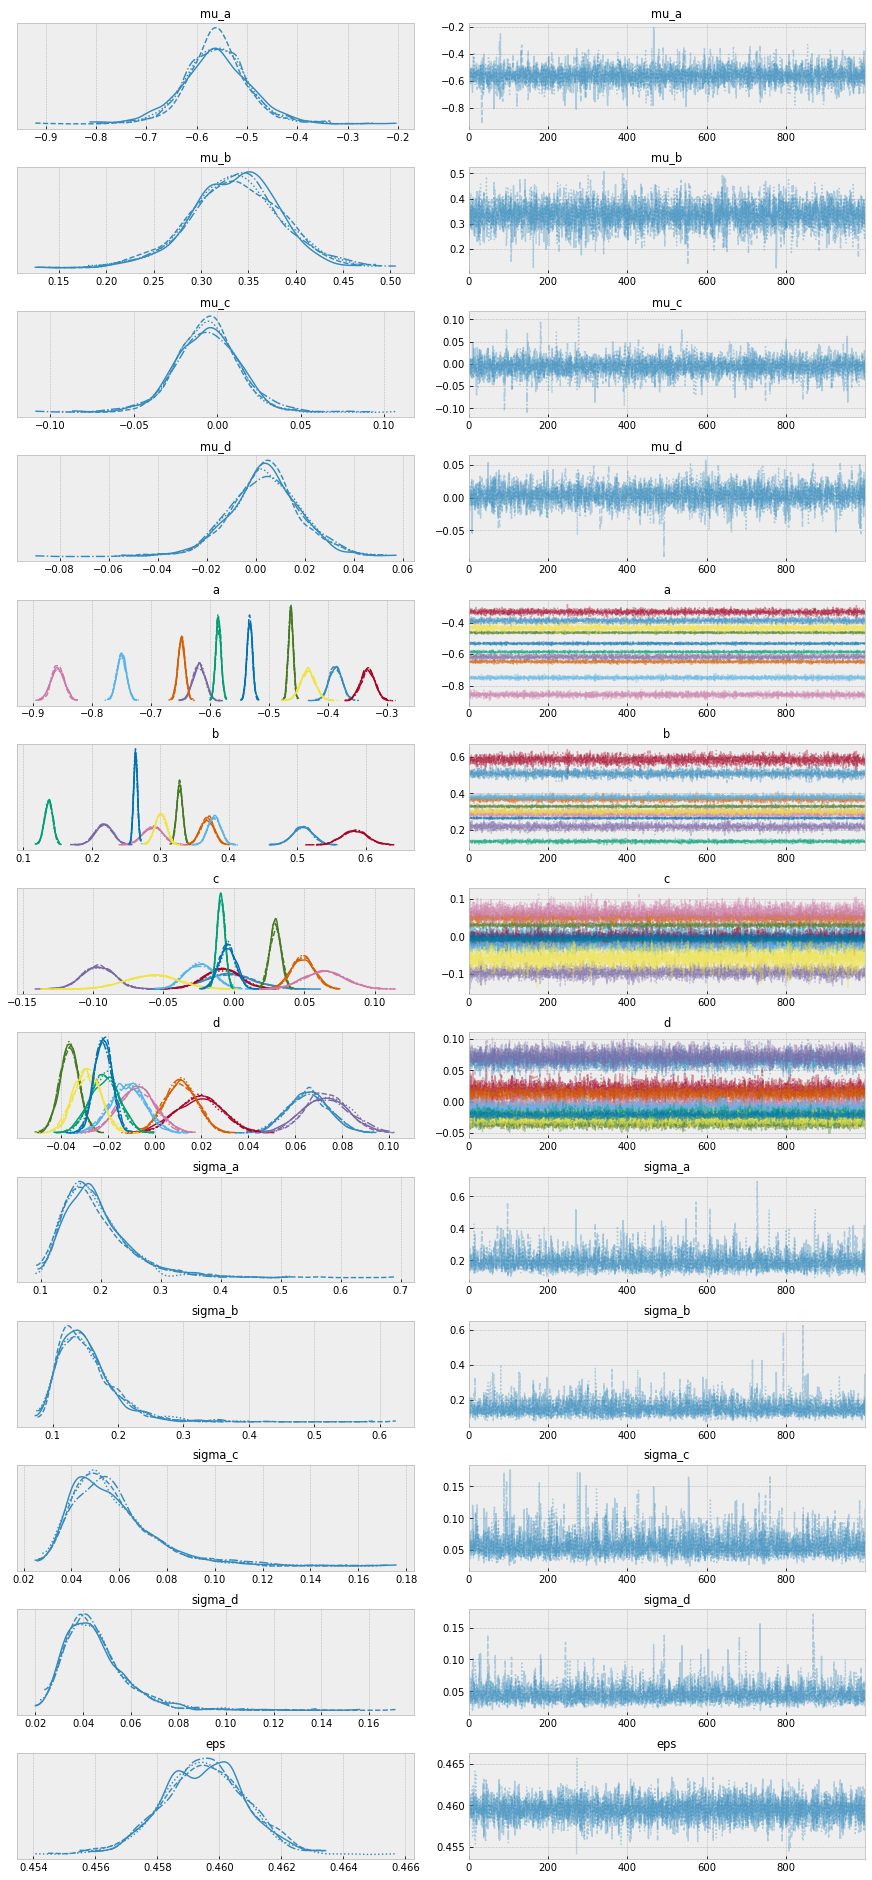

In [75]:
traceplot(cost_trace)

<ipython-input-170-1fa944ee5038>:7: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(rate_trace, 'ridgeplot', var_names=['intercept'], # change rate_trace to cost_trace
<ipython-input-170-1fa944ee5038>:15: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(rate_trace, 'ridgeplot', var_names=['distance_coef'], # change rate_trace to cost_trace
<ipython-input-170-1fa944ee5038>:23: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  pm.forestplot(rate_trace, 'ridgeplot', var_names=['weight_coef'], # change rate_trace to cost_trace
<ipython-input-170-1fa944ee5038>:31: DeprecationWarning: The function `forestplot` from P

Text(-0.03, 0.5, 'ZipZone_origin')

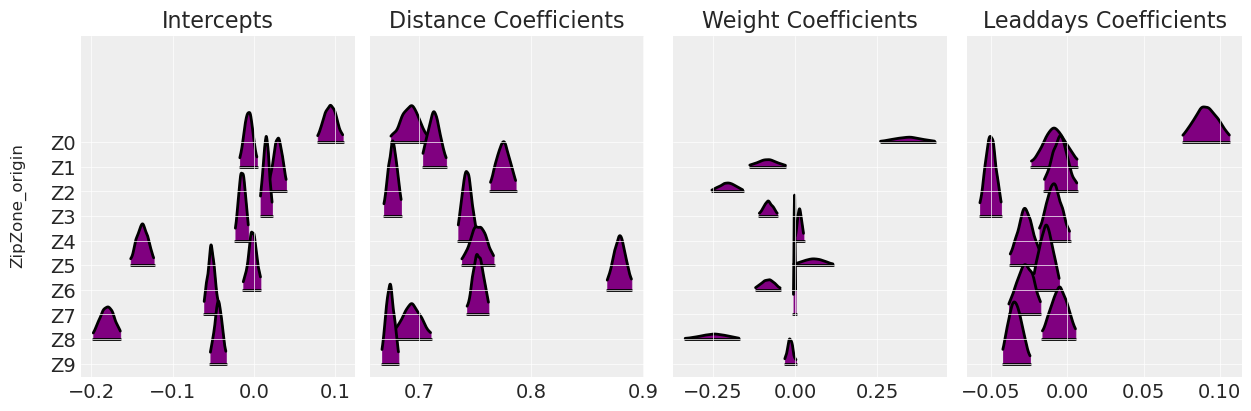

In [170]:
fig, ax = plt.subplots(1,4, sharey=True, figsize = (12,4), constrained_layout=True)

zz_ids  = sch_le.classes_[::-1]

az.style.use("arviz-darkgrid")

pm.forestplot(rate_trace, 'ridgeplot', var_names=['intercept'], # change rate_trace to cost_trace
              combined=True,
              ridgeplot_overlap=8,
              colors='purple',
              figsize=(10, 10), ax=ax[0])
ax[0].set_title('Intercepts')
ax[0].set_yticklabels(zz_ids)
ax[0].grid()
pm.forestplot(rate_trace, 'ridgeplot', var_names=['distance_coef'], # change rate_trace to cost_trace
              combined=True,
              ridgeplot_overlap=8,
              colors='purple',
              figsize=(10, 10), ax=ax[1])
ax[1].set_title('Distance Coefficients')
ax[1].set_yticklabels(zz_ids)
ax[1].grid()
pm.forestplot(rate_trace, 'ridgeplot', var_names=['weight_coef'], # change rate_trace to cost_trace
              combined=True,
              ridgeplot_overlap=12,
              colors='purple',
              figsize=(10, 10), ax=ax[2])
ax[2].set_title('Weight Coefficients')
ax[2].set_yticklabels(zz_ids)
ax[2].grid()
pm.forestplot(rate_trace, 'ridgeplot', var_names=['leaddays_coef'], # change rate_trace to cost_trace
              combined=True,
              ridgeplot_overlap=8,
              colors='purple',
              figsize=(10, 10), ax=ax[3])
ax[3].set_title('Leaddays Coefficients')
ax[3].set_yticklabels(zz_ids)
ax[3].grid()


fig.text(-0.03, 0.5, 'ZipZone_origin', va='center',  rotation='vertical', fontsize=12)

C:\Users\laure\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\laure\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


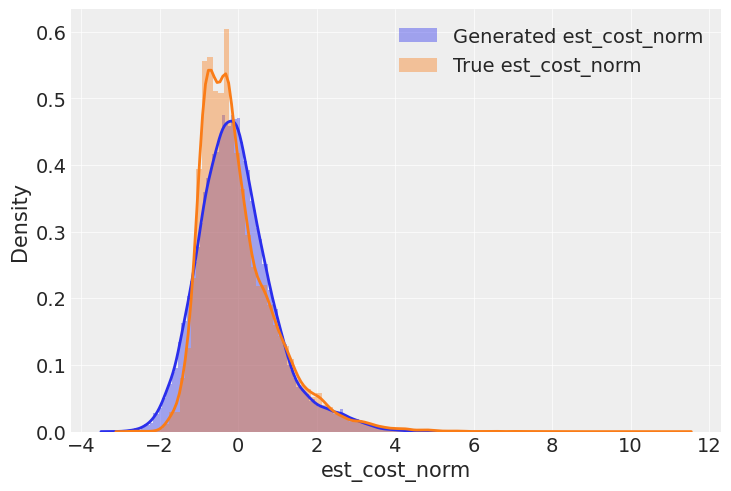

In [173]:
fig, ax = plt.subplots()
x = cost_post_pred["y_like"][0,0:len(Z3_distance)]
y = Z3_data['est_cost_norm']
label = ['Generated est_cost_norm', 'True est_cost_norm']
i = 0
for a in [x, y]:
    sns.distplot(a, bins=100, ax=ax, label = label[i])
    i += 1
plt.legend(loc='upper right')

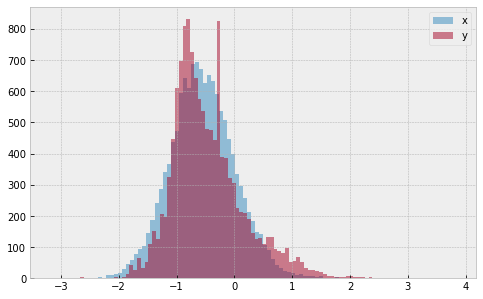

In [43]:
plt.hist(cost_post_pred["y_like"][0,0:len(Z3_distance)], bins=100, alpha=0.5, label='predicted est_cost_norm')
plt.hist(Z3_data['est_cost_norm'], bins=100, alpha=0.5, label='observed est_cost_norm')
plt.legend(loc='upper right')
plt.show()

# Generating independent variables for Z3 to Z3 and predicting on this data with our models

In [11]:
df_order_Z33 = data[(data['ZipZone_origin'] == 'Z3') & (data['ZipZone_dest'] == 'Z3')]
df_order_Z33.shape

(13270, 21)

In [12]:
import scipy.stats as st
from scipy.stats import multinomial
import statsmodels.datasets

In [13]:
# Generated data for order_distance, order_origin_weight, and lead_days

generated_distance = st.beta.rvs(a = 1.6166543818567054, b = 14.257852925372548, loc=-8.138430196487509, scale=2610.9946035470375, 
                                 size=13000, random_state=43)

generated_weight = st.foldcauchy.rvs(c = 19.444213307451193, loc = 0.9999997500622153, scale = 2228.2110592295912, size = 13000, 
                                     random_state=43)

all = df_order_Z33.shape[0]
p_lead_days = np.empty(df_order_Z33['lead_days'].max()+1)
n = 0
while n <= df_order_Z33['lead_days'].max():
    p_lead_days[n] = df_order_Z33[df_order_Z33['lead_days']==n].shape[0]/all
    n += 1
a_lead_days = multinomial.rvs(n=1, p=p_lead_days, size=13000, random_state=43)
generated_lead_days = np.zeros((13000,), dtype=int)
for i in range(13000):
    for j in range(df_order_Z33['lead_days'].max()):
        if a_lead_days[i,j] == 1:
            generated_lead_days[i]= j

In [16]:
generated_data = pd.DataFrame({'order_distance': generated_distance, 'order_origin_weight': generated_weight, 
                               'lead_days': generated_lead_days})

generated_data['order_distance_norm'] = (generated_data['order_distance'] - generated_data['order_distance'].mean())/(generated_data['order_distance'].std())
generated_data['weight_norm'] = (generated_data['order_origin_weight'] - generated_data['order_origin_weight'].mean())/(generated_data['order_origin_weight'].std())
generated_data['lead_days_norm'] = (generated_data['lead_days'] - generated_data['lead_days'].mean())/(generated_data['lead_days'].std())

In [65]:
gen_distance = np.array(generated_data.order_distance_norm.values.tolist())
gen_weight = np.array(generated_data.weight_norm.values.tolist())
gen_leaddays = np.array(generated_data.lead_days_norm.values.tolist())

In [66]:
# Generate rate_norm using the synthetic data
with rate_model:
    # change the value and shape of the data
    pm.set_data(
        {
            "distance": np.concatenate((gen_distance, np.empty((data.shape)[0] - len(gen_distance)))),
            "weight": np.concatenate((gen_weight, np.empty((data.shape)[0] - len(gen_weight)))),
            "leaddays": np.concatenate((gen_leaddays, np.empty((data.shape)[0] - len(gen_leaddays)))),
            # use dummy values with the same shape:
            "rate": np.empty(data.shape[0]),
        }
    )
    rate_post_pred = pm.sample_posterior_predictive(rate_trace, var_names=['y_like'])

In [68]:
generated_rate = rate_post_pred["y_like"][0,0:13000]

In [70]:
generated_rate.mean()

-0.5052386891109787

In [76]:
# Generate est_cost_norm using the synthetic data
with cost_model:
    # change the value and shape of the data
    pm.set_data(
        {
            "distance": np.concatenate((gen_distance, np.empty((data.shape)[0] - len(gen_distance)))),
            "weight": np.concatenate((gen_weight, np.empty((data.shape)[0] - len(gen_weight)))),
            "leaddays": np.concatenate((gen_leaddays, np.empty((data.shape)[0] - len(gen_leaddays)))),
            # use dummy values with the same shape:
            "cost": np.empty(data.shape[0]),
        }
    )
    cost_post_pred = pm.sample_posterior_predictive(cost_trace, var_names=['y_like'])

In [77]:
generated_cost = cost_post_pred["y_like"][0,0:13000]

In [78]:
generated_cost.mean()

-0.5540362091242821

In [81]:
generated_data = generated_data.assign(rate_norm=generated_rate, est_cost_norm=generated_cost)

In [86]:
generated_data = generated_data.drop(['order_distance_norm', 'weight_norm', 'lead_days_norm'], axis=1)

In [87]:
generated_data.head()

,order_distance,order_origin_weight,lead_days,rate_norm,est_cost_norm
0,328.257701,37433.077412,5,-0.909170,-0.203808
1,431.908489,44121.642933,5,0.139150,-1.555251
2,543.955732,38324.604726,7,0.363895,-0.039376
3,137.859769,40962.797911,1,-0.059074,-0.824165
4,318.670795,41981.874131,1,0.237177,-0.865398


In [88]:
generated_data.to_csv('generated_data.csv',index=False)

(0.0, 40.0)

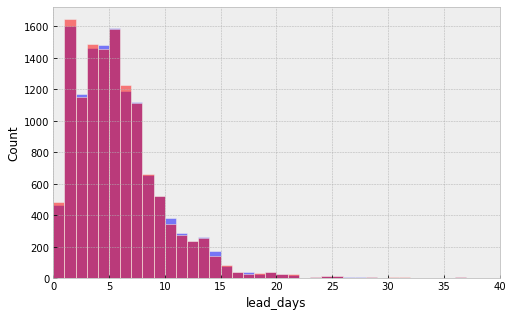

In [44]:
fig, ax = plt.subplots()
x = df_order_Z33['lead_days'].iloc[0:13000,]
y = generated_lead_days
#for a in [x, y]:
sns.histplot(x, ax=ax, alpha=0.5, color='blue', binwidth=1)
sns.histplot(y, ax=ax, alpha=0.5, color='red', binwidth=1)
#ax.set_xlabel("order_distance")
#ax.set_ylabel("count")
#ax.legend()
ax.set_xlim(0, 40)

(0.0, 40.0)

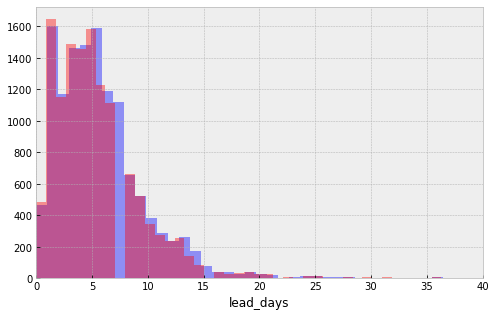

In [56]:
fig, ax = plt.subplots()
x = df_order_Z33['lead_days'].iloc[0:13000,]
y = generated_lead_days
#for a in [x, y]:
sns.distplot(x, ax=ax, color='blue', kde=False, bins=70)
sns.distplot(y, ax=ax, color='red', kde=False, bins=70)
#ax.set_xlabel("order_distance")
#ax.set_ylabel("count")
#ax.legend()
ax.set_xlim(0, 40)

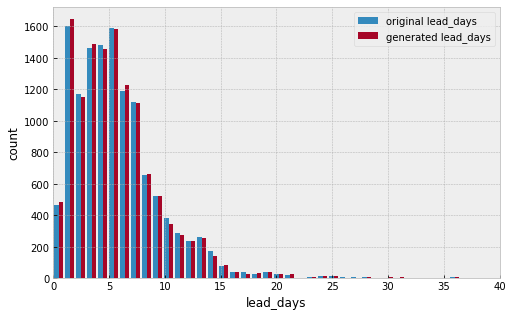

In [73]:
import matplotlib
plt.hist([x, y], bins=70, label=['original lead_days', 'generated lead_days'])
plt.legend(loc='upper right')
plt.xlim([0,40])
plt.xlabel("lead_days")
plt.ylabel("count")
#matplotlib.axes.Axes.set_xlabel(xlabel='lead_days')
#matplotlib.axes.Axes.set_ylabel(ylabel='count')
plt.show()